In [1]:
%load_ext autoreload
%autoreload 2

import re
import latools as la

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
d = la.analyse('./tests/test_dir/test_data', internal_standard="Ca43")
d.despike(expdecay_despiker=True, noise_despiker=True)
d.autorange(on_mult=[1.5, 0.8],
            off_mult=[0.8, 1.5])

d.bkg_calc_weightedmean()
d.bkg_subtract()
d.ratio()
d.calibrate(drift_correct=False, n_min=10,
            srms_used=['NIST610', 'NIST612', 'NIST614'])

Starting analysis using "UCD-AGILENT" configuration:
  5 Data Files Loaded: 2 standards, 3 samples
  Analytes: Mg24 Mg25 Al27 Ca43 Ca44 Mn55 Sr88 Ba137 Ba138
  Internal Standard: Ca43
Calculating exponential decay coefficient
from SRM washouts...
  -2.29


Applying Calibrations: 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]


In [3]:
d.get_focus()

In [6]:
d.calib_params

,Al27,Ba137,Ba138,Ca44,Mg24,Mg25,Mn55,Sr88
,m,m,m,m,m,m,m,m
0.000000,0.00578+/-0.00029,0.00240+/-0.00012,0.000379+/-0.000019,0.0638+/-0.0031,0.0067+/-0.0004,0.0501+/-0.0028,0.00122+/-0.00007,0.000530+/-0.000026
129.255454,0.00578+/-0.00029,0.00240+/-0.00012,0.000379+/-0.000019,0.0638+/-0.0031,0.0067+/-0.0004,0.0501+/-0.0028,0.00122+/-0.00007,0.000530+/-0.000026
1280.255454,0.00578+/-0.00029,0.00240+/-0.00012,0.000379+/-0.000019,0.0638+/-0.0031,0.0067+/-0.0004,0.0501+/-0.0028,0.00122+/-0.00007,0.000530+/-0.000026
1400.571000,0.00578+/-0.00029,0.00240+/-0.00012,0.000379+/-0.000019,0.0638+/-0.0031,0.0067+/-0.0004,0.0501+/-0.0028,0.00122+/-0.00007,0.000530+/-0.000026


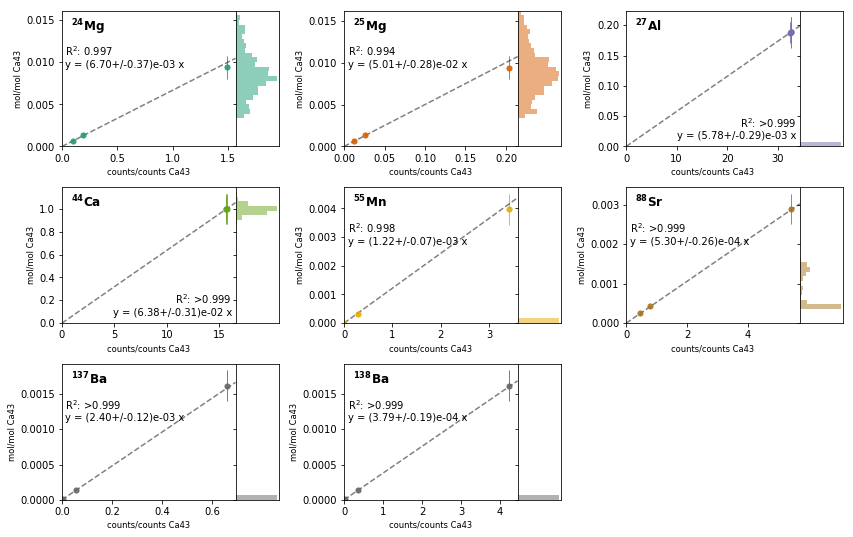

In [4]:
_ = d.calibration_plot()

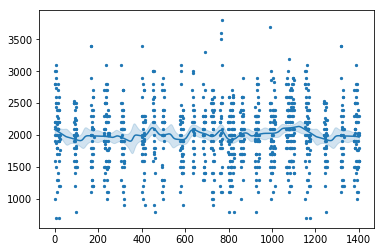

In [28]:
a = 'Al27'

plt.scatter(d.bkg['raw'].uTime, d.bkg['raw'].loc[:, a], s=5)

plt.plot(d.bkg['calc']['uTime'],
         d.bkg['calc'][a]['mean'])

plt.fill_between(d.bkg['calc']['uTime'],
                 d.bkg['calc'][a]['mean'] - d.bkg['calc'][a]['stderr'],
                 d.bkg['calc'][a]['mean'] + d.bkg['calc'][a]['stderr'], alpha=0.2, color='C0')

# d.bkg['raw']

Plotting backgrounds: 100%|██████████| 1/1 [00:00<00:00, 19.75it/s]


(<Figure size 540x360 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7fe7290bf908>)

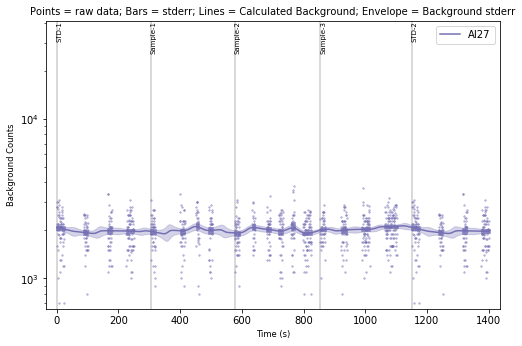

In [13]:
d.bkg_plot('Al27')

In [17]:
di = d.data['STD-1']

In [18]:
import uncertainties.unumpy as un

In [23]:
el = 'Ca44'

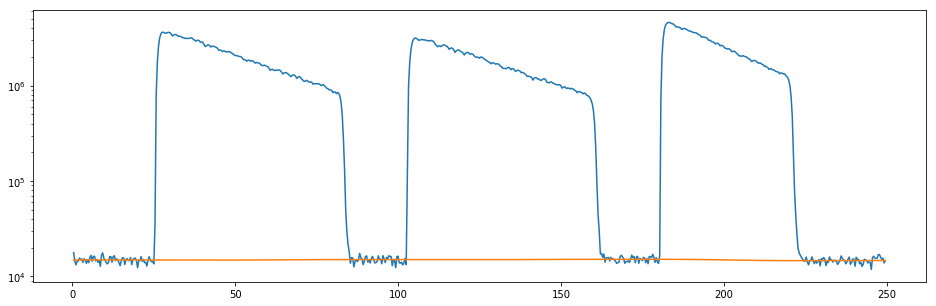

In [33]:
fig, ax = plt.subplots(1,1,figsize=[16, 5])

ax.plot(di.data['Time'], di.data['despiked'][el])
ax.set_yscale('log')

ax.plot(di.data['Time'], un.nominal_values(d.bkg_interps[el].new(di.uTime)))

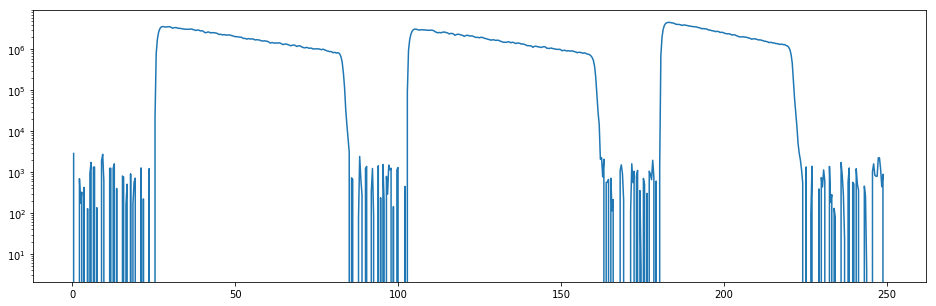

In [35]:
fig, ax = plt.subplots(1,1,figsize=[16, 5])

ax.plot(di.data['Time'], di.data['despiked'][el] - un.nominal_values(d.bkg_interps[el].new(di.uTime)))
ax.set_yscale('log')

# plt.ylim(1, 100)
# plt.xlim(0, 10)

In [4]:
d.get_focus()

In [45]:
d.focus

{'Al27': array([3090.6357727965415+/-0.996005933844725,
        1890.468906767269+/-0.995816573990732,
        1957.1586876993042+/-0.995631097803064, ...,
        2390.0062061604704+/-0.883454163267519,
        1389.9029880916023+/-0.8837848164239073,
        1889.9398060795284+/-0.8841117647830249], dtype=object),
 'Ba137': array([27.86577279654132+/-0.996005933844725,
        15.368906767268973+/-0.995816573990732,
        -9.627978967362294+/-0.995631097803064, ...,
        -10.153793839529449+/-0.883454163267519,
        -10.157011908397545+/-0.8837848164239073,
        14.839806079528403+/-0.8841117647830249], dtype=object),
 'Ba138': array([nan, nan, nan, ..., nan, nan, nan], dtype=object),
 'Ca43': array([290.3657727965413+/-0.996005933844725,
        257.038906767269+/-0.995816573990732,
        223.70202103263773+/-0.995631097803064, ...,
        256.5162061604706+/-0.883454163267519,
        323.18298809160245+/-0.8837848164239073,
        356.5098060795284+/-0.8841117647830

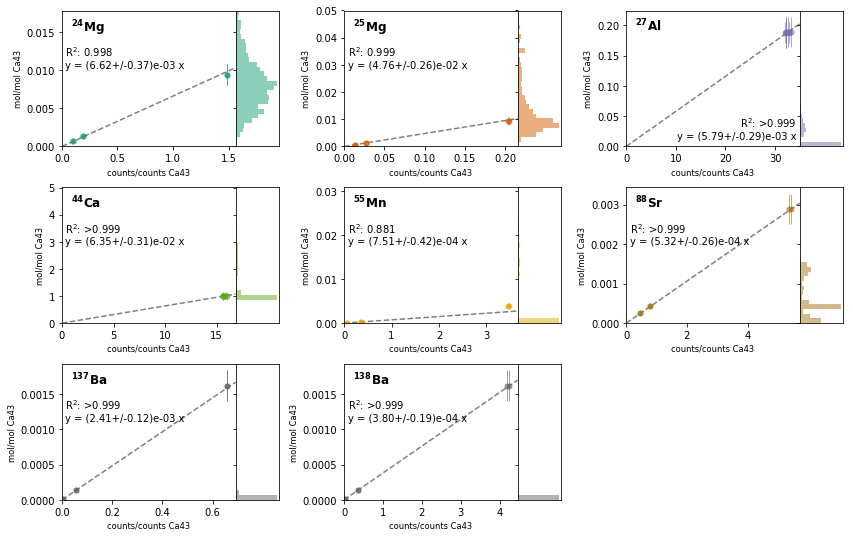

In [21]:
fig, axs = d.calibration_plot()

In [13]:
d.get_focus()

In [15]:
for k, v in d.focus.items():
    print(k, len(v))

uTime 2097
Mg24 2097
Mg25 2097
Al27 2097
Ca43 2097
Ca44 2097
Mn55 2097
Sr88 2097
Ba137 2097
Ba138 2097


In [33]:
di = d.data['Sample-1']
calib = d.calib_ps['Ba138']['m']

In [34]:
calib.new(di.uTime)

array([0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.8958022764983658e-05,
       0.00038045551172148244+/-1.89580227649836

In [38]:
d.set_focus('bkgsub')
d.get_focus()
d.focus

{'Al27': array([3090.6357727965415+/-0.996005933844725,
        1890.468906767269+/-0.995816573990732,
        1957.1586876993042+/-0.995631097803064, ...,
        2390.0062061604704+/-0.883454163267519,
        1389.9029880916023+/-0.8837848164239073,
        1889.9398060795284+/-0.8841117647830249], dtype=object),
 'Ba137': array([27.86577279654132+/-0.996005933844725,
        15.368906767268973+/-0.995816573990732,
        -9.627978967362294+/-0.995631097803064, ...,
        -10.153793839529449+/-0.883454163267519,
        -10.157011908397545+/-0.8837848164239073,
        14.839806079528403+/-0.8841117647830249], dtype=object),
 'Ba138': array([nan, nan, nan, ..., nan, nan, nan], dtype=object),
 'Ca43': array([290.3657727965413+/-0.996005933844725,
        257.038906767269+/-0.995816573990732,
        223.70202103263773+/-0.995631097803064, ...,
        256.5162061604706+/-0.883454163267519,
        323.18298809160245+/-0.8837848164239073,
        356.5098060795284+/-0.8841117647830

Drawing Plots:   0%|          | 0/28 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (1116,) (2097,) 

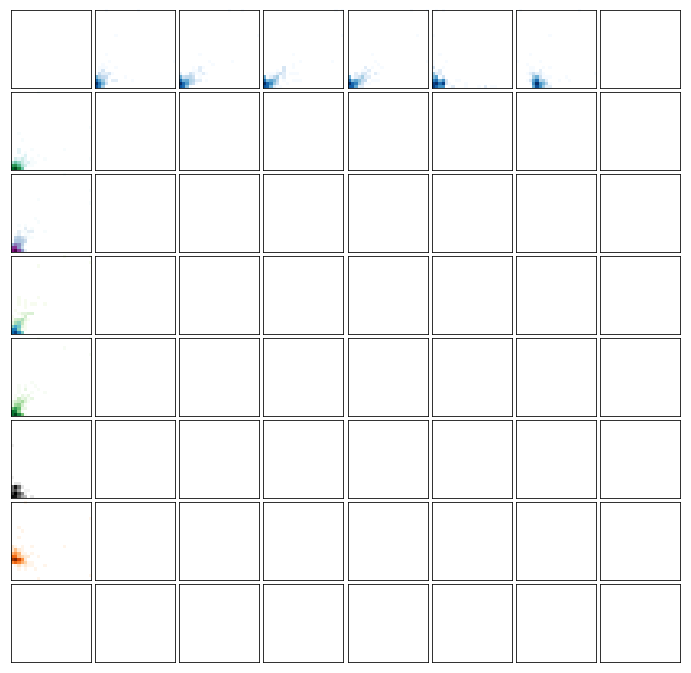

In [12]:
fig, axs = d.crossplot(save=True)

In [2]:
d = la.analyse('tests/test_dir/test_data/')
d.despike()
d.autorange()
d.bkg_calc_weightedmean()
d.bkg_subtract()
d.ratio()
d.calibrate()

AutoRange:  20%|██        | 1/5 [00:00<00:00,  8.93it/s]

Starting analysis using "UCD-AGILENT" configuration:
  5 Data Files Loaded: 2 standards, 3 samples
  Analytes: Mg24 Mg25 Al27 Ca43 Ca44 Mn55 Sr88 Ba137 Ba138
  Internal Standard: Ca43


Applying Calibrations: 100%|██████████| 5/5 [00:00<00:00, 10.06it/s]


In [265]:
d.minimal_export()

In [50]:
import os
import re
import inspect

In [118]:
from latools import *

In [241]:
from latools.helpers import utils

In [254]:
os.path.abspath(log_file)

'/home/oscar/GitHub/latools/tests/test_dir/test_data_export/minimal_export/analysis.log'

In [53]:
la.helpers.utils.read_logfile('tests/test_dir/test_data_export/minimal_export/analysis.log')

({'__init__': {'args': (),
   'kwargs': {'cmap': None,
    'config': 'REPRODUCE',
    'data_folder': 'tests/test_dir/test_data_export/minimal_export/./data/',
    'dataformat': None,
    'errorhunt': False,
    'extension': '.csv',
    'internal_standard': 'Ca43',
    'names': 'file_names',
    'srm_file': 'tests/test_dir/test_data_export/minimal_export/./srm.table',
    'srm_identifier': 'STD',
    'time_format': None}},
  'apply_classifier': {'args': ('test',), 'kwargs': {}},
  'autorange': {'args': (),
   'kwargs': {'off_mult': [0.8, 1.5], 'on_mult': [1.5, 0.8]}},
  'bkg_calc_weightedmean': {'args': (),
   'kwargs': {'n_min': 10, 'weight_fwhm': 300}},
  'bkg_plot': {'args': (), 'kwargs': {}},
  'bkg_subtract': {'args': (), 'kwargs': {}},
  'calibrate': {'args': (),
   'kwargs': {'drift_correct': False,
    'n_min': 10,
    'srms_used': ['NIST610', 'NIST612', 'NIST614']}},
  'calibration_plot': {'args': (), 'kwargs': {}},
  'crossplot': {'args': (), 'kwargs': {'save': True}},
  'desp

In [ ]:
la.analyse()

In [261]:

log_file = 'tests/test_dir/test_data_export/minimal_export/analysis.log'

# create dictionary of special function relations

def read_logfile(log_file):
    dirname = os.path.dirname(log_file) + '/'
    
    with open(log_file, 'r') as f:
        rlog = f.readlines()

    hashind = [i for i, n in enumerate(rlog) if '#' in n]

    pathread = re.compile('(.*) :: (.*)\n')
    paths = (pathread.match(l).groups() for l in rlog[hashind[0] + 1:hashind[-1]] if pathread.match(l))
    paths = {k: os.path.join(dirname, v) for k, v in paths}

    logread = re.compile('([a-z_]+) :: args=(\(.*\)) kwargs=(\{.*\})')
    runargs = {}
    for line in rlog[hashind[1] + 1:]:
        fname, args, kwargs = (logread.match(line).groups())
        runargs[fname] = {'args': eval(args), 'kwargs': eval(kwargs)}
        
        if fname == '__init__':
            runargs[fname]['kwargs']['config'] = 'REPRODUCE'
            runargs[fname]['kwargs']['dataformat'] = None
            runargs[fname]['kwargs']['data_folder'] = paths['data_folder']

    return runargs, paths


# def reproduce(past_analysis, plotting=False):
#     if '.zip' in past_analysis:
#         utils.extract_zipdir(past_analysis)
#         logpath = os.path.join(os.path.dirname(past_analysis),
#                                os.path.basename(past_analysis).replace('.zip', ''),
#                                'analysis.log')
#     elif os.path.isdir(past_analysis):
#         if os.path.exists(os.path.join(past_analysis, 'analysis.log')):
#             logpath = os.path.join(past_analysis, 'analysis.log')
#     elif 'analysis.log' in past_analysis:
#         logpath = past_analysis
#     else:
#         raise ValueError(('\n\n{} is not a valid input.\n\n' + 
#                           'Must be one of:\n' +
#                           '  - A .zip file exported by latools\n' + 
#                           '  - An analysis.log file\n' +
#                           '  - A directory containing an analysis.log files\n'))

#     runargs, paths = read_logfile(logpath)
    
#     rep = analyse(*runargs['__init__']['args'], **runargs['__init__']['kwargs'])
    
#     for fname, arg in runargs.items():
#         if fname != '__init__':
#             if 'plot' in fname and not plotting:
#                 getattr(rep, fname)(*arg['args'], **arg['kwargs'])
#             elif 'sample_stats' in fname

    

#     if fname in fn_map:
#         fsig = inspect.signature(fn_map[fname])
#     else:
#         fsig = inspect.signature(getattr(analyse, fname))
    


# init_kwargs = eval(logread.match(rlog[hashind[1] + 1]).groups()[-1])
# init_kwargs['config'] = 'REPRODUCE'
# init_kwargs['dataformat'] = None
# init_kwargs['data_folder'] = 


# dat = la.analyse(*init_kwargs)

In [262]:
read_logfile(log_file)

({'__init__': {'args': (),
   'kwargs': {'cmap': None,
    'config': 'REPRODUCE',
    'data_folder': 'tests/test_dir/test_data_export/minimal_export/./data/',
    'dataformat': None,
    'errorhunt': False,
    'extension': '.csv',
    'internal_standard': 'Ca43',
    'names': 'file_names',
    'srm_file': None,
    'srm_identifier': 'STD',
    'time_format': None}},
  'autorange': {'args': (), 'kwargs': {}},
  'bkg_calc_weightedmean': {'args': (), 'kwargs': {}},
  'bkg_subtract': {'args': (), 'kwargs': {}},
  'calibrate': {'args': (), 'kwargs': {}},
  'despike': {'args': (), 'kwargs': {}},
  'ratio': {'args': (), 'kwargs': {}}},
 {'data_folder': 'tests/test_dir/test_data_export/minimal_export/./data/',
  'srm_table': 'tests/test_dir/test_data_export/minimal_export/./srm.table'})

In [104]:
inspect.getargspec(la.analyse)

ArgSpec(args=['self', 'data_folder', 'errorhunt', 'config', 'dataformat', 'extension', 'srm_identifier', 'cmap', 'time_format', 'internal_standard', 'names', 'srm_file'], varargs=None, keywords=None, defaults=(False, 'DEFAULT', None, '.csv', 'STD', None, None, 'Ca43', 'file_names', None))

In [105]:
s = inspect.signature(la.analyse)
ba = s.bind(*(), **init_kwargs)


In [106]:
_, cf = la.helpers.config.read_latoolscfg()

In [110]:
la.analyse(**ba.arguments)

Starting analysis using "REPRODUCE" configuration:
  5 Data Files Loaded: 2 standards, 3 samples
  Analytes: Al27 Ba137 Ba138 Ca43 Ca44 Mg24 Mg25 Mn55 Sr88
  Internal Standard: Ca43


In [266]:
r = la.reproduce(log_file)

AutoRange:  20%|██        | 1/5 [00:00<00:00,  8.86it/s]

Starting analysis using "REPRODUCE" configuration:
  5 Data Files Loaded: 2 standards, 3 samples
  Analytes: Al27 Ba137 Ba138 Ca43 Ca44 Mg24 Mg25 Mn55 Sr88
  Internal Standard: Ca43


Applying Calibrations: 100%|██████████| 5/5 [00:00<00:00,  7.61it/s]


In [273]:
d.subsets

{'All_Analyses': array(['STD-1', 'Sample-1', 'Sample-2', 'Sample-3', 'STD-2'], dtype=object),
 'All_Samples': ['Sample-1', 'Sample-2', 'Sample-3'],
 'STD': ['STD-1', 'STD-2'],
 'not_in_set': ['Sample-1', 'Sample-2', 'Sample-3']}

In [46]:
init_kwargs

{'cmap': None,
 'config': 'REPRODUCE',
 'data_folder': 'tests/test_dir/test_data_export/minimal_export/./data/',
 'dataformat': None,
 'errorhunt': False,
 'extension': '.csv',
 'internal_standard': 'Ca43',
 'names': 'file_names',
 'srm_file': None,
 'srm_identifier': 'STD',
 'time_format': None}

In [48]:
eval(logread.match(rlog[hashind[1] + 1]).groups()[-1])

{'cmap': None,
 'config': 'DEFAULT',
 'data_folder': 'tests/test_dir/test_data/',
 'dataformat': None,
 'errorhunt': False,
 'extension': '.csv',
 'internal_standard': 'Ca43',
 'names': 'file_names',
 'srm_file': None,
 'srm_identifier': 'STD',
 'time_format': None}

## Detection Limit Calculation

## Data Format Tester

In [35]:
import latools as la
import configparser
import json
import os, re
import numpy as np
import pkg_resources as pkgrs
from latools.helpers.helpers import Bunch

from shutil import copyfile

In [94]:
config = la.config.read_configuration()
fdataformat = './UCD_dataformat.json'

In [98]:
with open(fdataformat) as f:
    dataformat = json.load(f)

In [99]:
dataformat

{'column_id': {'delimiter': ',',
  'name_row': 3,
  'pattern': '([A-z]{1,2}[0-9]{1,3})',
  'timecolumn': 0},
 'genfromtext_args': {'delimiter': '2,', 'skip_header': 4},
 'meta_regex': {'0': [['path'], '(.*)'],
  '2': [['date', 'method'],
   '([A-Z][a-z]+ [0-9]+ [0-9]{4}[ ]+[0-9:]+ [amp]+).* ([A-z0-9]+\\.m)']},
 'unit': 'cps'}

In [11]:
ls 'latools/resources/test_data/'

Sample-1.csv  Sample-2.csv  Sample-3.csv  STD-1.csv  STD-2.csv


In [105]:
%load_ext autoreload
%autoreload 2

from latools.helpers.config import test_dataformat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
test_dataformat('latools/resources/test_data/STD-1.csv', fdataformat, 'file_names')

*************************************************
Testing suitability of data format description...
  Dataformat File: ./UCD_dataformat.json
  Data File: latools/resources/test_data/STD-1.csv
*************************************************
  Test: open data file...
    Success!
  Test: read dataformat file...
    Success!
  Test: read metadata using 'metadata_regex'...
    Line 2: date: Oct 29 2015  03:06:01 pm
    Finished - does the above look correct?
  Test: Sample Name IDs...
    Sample name grabbed from file: STD-1
        ***Is the sample name correct?***
  Test: Getting Column Names...
    Columns from line 3: Time [Sec], Mg24, Mg25, Al27, Ca43, Ca44, Mn55, Sr88, Ba137, Ba138
    Cleaning up using column_id/pattern...
    Cleaned Analyte Names: Ca43, Ca44, Ba137, Ba138
        ***This should only contain analyte names... does it?***
  Test: Reading Data...
    checking dimensions...
        ***PROBLEM: There are 10 data columns, but 5 column names.
        Check your identifi

ValueError: Data - Column Name mismatch